Project Week03

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np
import sys
import time

- Problem 1

Use the stock returns in DailyReturn.csv for this problem. DailyReturn.csv contains returns for 100 large US stocks and as well as the ETF, SPY which tracks the S&P500.

Create a routine for calculating an exponentially weighted covariance matrix. If you have a package that calculates it for you, verify that it calculates the values you expect. This means you still have to implement it.

Vary λ ∈ (0, 1). Use PCA and plot the cumulative variance explained by each eigenvalue for each λ chosen.

What does this tell us about values of λ and the effect it has on the covariance matrix?


In [4]:
def calculate_ewma_covariance_matrix(df, lambd):
    # Get the number of time steps n and vars m
    n, m = df.shape  
    
    # Initialize the exponentially weighted covariance matrix as a square matrix with dimensions (m, m)
    ewma_cov_matrix = np.zeros((m, m))  
    
    # Calculate the weights and normalized weights for each time step
    # w_{t_i} = (1-lambda)*lambda^{i-1}
    weights = [(1 - lambd) * lambd**(i) for i in range(n)]  
    weights = weights[::-1]
    #### Flip the weights

    # Calculate the sum of weights to normalize them
    total_weight = sum(weights)  # sum w_{t-j}
    
    # Normalize the weights by dividing each weight by the total weight
    # w_{t_i}^hat = w_{t_i} / sum w_{t-j}
    normalized_weights = [w / total_weight for w in weights]  
    
    # Calculate the means for each variable across all time steps
    means = df.mean()  
    
    # Calculate the exponentially weighted covariance matrix
    for t in range(n):
        # Calculate the deviation of each variable at time t from its mean
        deviation = df.iloc[t, :] - means  
        
        # weighted deviation from means for x and y
        ### NEED TO PERFORM ELEMENT WISE OPERATION, FIX THIS
        ewma_cov_matrix += normalized_weights[t] * deviation.values.reshape(-1, 1) @ deviation.values.reshape(1, -1)
    ewma_cov_matrix = pd.DataFrame(ewma_cov_matrix)
    return ewma_cov_matrix

Frobenius Norm between unweighted covar matrix and my exp. weighted covar matrix 0.029394352775740665


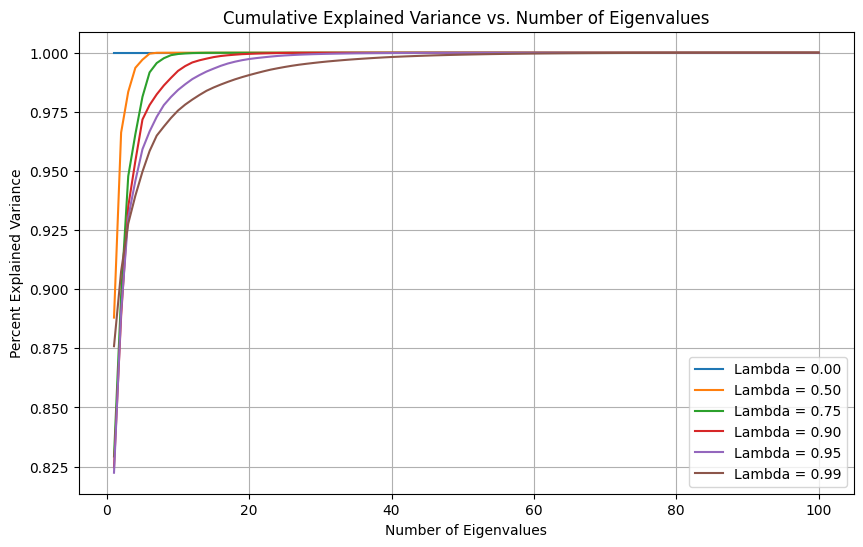

In [5]:
# Use DailyReturn.csv
dailyreturn = pd.read_csv('/Users/ahmedibrahim/Desktop/Mids/Fall24/Quantitative Risk Management/exam prep/try_juhas/week03_answers/Project/DailyReturn.csv')

# Rename the first column to "Date" and setting to index column
dailyreturn.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
dailyreturn.set_index('Date', inplace=True)

# Calculate the exponentially weighted covariance matrix using your function
v_df = calculate_ewma_covariance_matrix(dailyreturn, 0)

#Compare to non-weighted covariance matrix
p = dailyreturn.cov()
frob = np.linalg.norm(v_df.values - p.values, 'fro')
print(f"Frobenius Norm between unweighted covar matrix and my exp. weighted covar matrix {frob}")

# Vary lambda from 0 to 1
lambda_values = np.linspace(0, 1.0, 16)

lambda_values = lambda_values[:-1]

lambda_values = [0, 0.5, 0.75, 0.9, 0.95, 0.99]
# Use PCA and plot the cumulative variance explained by each eigenvalue for each lambda chosen
explained_variances = []

# Loop through different lambda values
for lambd in lambda_values:
    # Calculate the exponentially weighted covariance matrix using your function
    v = calculate_ewma_covariance_matrix(dailyreturn, lambd)
    v_df = pd.DataFrame(v)
    
    # Calculate the eigenvalues of v_df
    eigenvalues = np.linalg.eigvals(v_df)
    
    # Calculate explained variance ratio using PCA
    pca = PCA()
    pca.fit(v_df)
    explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    
    explained_variances.append(explained_variance_ratio)

# Plot the cumulative explained variance for each lambda
plt.figure(figsize=(10, 6))
for i, lambd in enumerate(lambda_values):
    plt.plot(range(1, len(explained_variances[i]) + 1), explained_variances[i], label=f'Lambda = {lambd:.2f}')

plt.xlabel('Number of Eigenvalues')
plt.ylabel('Percent Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Eigenvalues')
plt.legend()
plt.grid(True)
# plt.savefig('Week03/Project/cum_exp_var_vs_num_eig.png')
plt.show()
# What does this tell us about the values of lambda and the effect it has on the covariance matrix?



- Problem 2
Copy the chol_psd(), and near_psd() functions from the course repository – implement in your programming language of choice. These are core functions you will need throughout the remainder of the class.

Implement Higham’s 2002 nearest psd correlation function.

Generate a non-psd correlation matrix that is 500x500. You can use the code I used in class:

n=500

sigma = fill(0.9,(n,n))
for i in 1:n
    sigma[i,i]=1.0
end
sigma[1,2] = 0.7357
sigma[2,1] = 0.7357

Use near_psd() and Higham’s method to fix the matrix. Confirm the matrix is now PSD.

Compare the results of both using the Frobenius Norm. Compare the run time between the two. How does the run time of each function compare as N increases?

Based on the above, discuss the pros and cons of each method and when you would use each. There is no wrong answer here, I want you to think through this and tell me what you think.

In [7]:
def chol_psd(root, a):
    n = a.shape[0]

    # Initialize the root matrix with 0 values
    root.fill(0.0)

    # Loop over columns
    for j in range(n):
        s = 0.0

        # If we are not on the first column, calculate the dot product of the preceding row values.
        if j > 0:
            s = np.dot(root[j, :j], root[j, :j])

        # Diagonal Element
        temp = a[j, j] - s
        if 0.0 >= temp >= -1e-8:
            temp = 0.0
        root[j, j] = np.sqrt(temp)

        # Check for the 0 eigenvalue. Just set the column to 0 if we have one
        if root[j, j] == 0.0:
            root[j, j+1:] = 0.0
        else:
            # Update off-diagonal rows of the column
            ir = 1.0 / root[j, j]
            for i in range(j+1, n):
                s = np.dot(root[i, :j], root[j, :j])
                root[i, j] = (a[i, j] - s) * ir
    return root

In [8]:
def is_psd(matrix):
    # Check if a matrix is positive semidefinite
    eigenvalues = np.linalg.eigvals(matrix)
    psd =  np.all(eigenvalues >= 0)
    if psd:
        print("The matrix is positive semidefinite.")
    else:
        print("The matrix is not positive semidefinite.")
        # Print the negative eigenvalues
        negative_eigenvalues = eigenvalues[eigenvalues < 0]
        print("Negative Eigenvalues:", negative_eigenvalues)

def near_psd(a, epsilon=0.0):
    n = a.shape[0]

    invSD = None
    out = a.copy()

    # Calculate the correlation matrix if we got a covariance
    if np.sum(np.isclose(np.diag(out), 1.0)) != n:
        invSD = np.diag(1.0 / np.sqrt(np.diag(out)))
        out = np.dot(np.dot(invSD, out), invSD)

    # SVD, update the eigenvalue and scale
    vals, vecs = np.linalg.eigh(out)

    vals = np.maximum(vals, epsilon)
   
    T = 1.0 / (vecs * vecs @ vals)
    T = np.diag(np.sqrt(T))
    l = np.diag(np.sqrt(vals))
    B = np.dot(np.dot(T, vecs), l)
    out = np.dot(B, B.T)

    # Add back the variance
    if invSD is not None:
        invSD = np.diag(1.0 / np.diag(invSD))
        out = np.dot(np.dot(invSD, out), invSD)

    return out

In [9]:
def higham_near_psd(a, epsilon = 0.0, max_iterations=100):
    # Initialize variables
    delta_S = np.zeros_like(a)  # Initialize Delta S_0 to zero
    X = np.copy(a)             # Initialize Y_0 as a copy of the input matrix a
    Y = np.copy(a)             # Initialize Y_0 as a copy of the input matrix a
    diffY = np.inf

    if not np.all((np.transpose(a) == a)):
        # Check if the input matrix is symmetric; needed for eigenvalue computation
        raise ValueError('Input Matrix is not symmetric')


    iteration = 0
    # Continue iterating until maximum iterations reached or until difference is within tolerance levels
    while iteration < max_iterations:
        iteration += 1
        if diffY < epsilon:
            break

        Yold = np.copy(Y)  # Store the previous Y (Y_k-1)
        R = Y - delta_S    # Calculate R_k = Y_(k-1) - Delta S_(k-1)
        
        # Compute the weighted R (R_k) using a diagonal weight matrix
        W = np.sqrt(np.diag(np.diag(Y)))  # Diagonal weight matrix W

        R_wtd = np.linalg.inv(W) @ (W @ R @ W) @ np.linalg.inv(W) # Apply weight matrix
        
        # Perform the projection onto the space of symmetric positive definite matrices
        d, v = np.linalg.eigh(R_wtd)
        X = v @ np.diag(np.maximum(d, 0)) @ v.T
        
        delta_S = X - R         # Calculate Delta S_k = X_k - R_k

        Y = np.copy(X)
        np.fill_diagonal(Y, 1)  # Y_k = P_U(X_k)
        
        # Compute norms for convergence checking
        ### change Y to Covar matrix
        diffY = np.linalg.norm(Y - Yold, 'fro') / np.linalg.norm(Y, 'fro') #lambda calc

    return X

In [11]:
n = 500
sigma = 0.9 * np.ones((n, n), dtype=np.float64)
np.fill_diagonal(sigma, 1.0)
sigma[0, 1] = 0.7357
sigma[1, 0] = 0.7357

is_psd(sigma)

# Initialize the root matrix
root = np.zeros((n, n), dtype=np.float64)

#Proof that near_psd convert a matrix into something usable by the Cholesky PSD function
a = near_psd(sigma)
is_psd(a)

chol_psd(root = root, a = a)
print("Since the Cholesky PDf function runs using the near_psd function, the matrix is now PSD")

# Initialize the root matrix
root = np.zeros((n, n), dtype=np.float64)

b = higham_near_psd(sigma)
is_psd(b)

chol_psd(root = root, a = b)
print("Since the Cholesky PDf function runs using the higham function, the matrix is now PSD")

#Example usage and verification
for n in (50, 100, 200, 500, 750, 1000):
    print("N:", n)
    sigma = 0.9 * np.ones((n, n), dtype=np.float64)
    np.fill_diagonal(sigma, 1.0)
    sigma[0, 1] = 0.7357
    sigma[1, 0] = 0.7357

    # Measure execution time for 'near_psd' function
    start_time = time.time()
    v = near_psd(sigma)
    end_time = time.time()
    near_psd_time = end_time - start_time

    # Print execution times
    print(f"Execution time for 'near_psd' function: {near_psd_time} seconds")
    is_psd(v)

    print(f"Frobenius Norm for near_psd is: {np.linalg.norm(v-sigma)}")
    # Measure execution time for 'higham_near_psd' function
    start_time = time.time()
    b = higham_near_psd(sigma)
    end_time = time.time()
    higham_near_psd_time = end_time - start_time

    print(f"Execution time for 'higham_near_psd' function: {higham_near_psd_time} seconds")
    is_psd(b)

    print(f"Frobenius Norm for Higham is: {np.linalg.norm(b-sigma)}")


The matrix is not positive semidefinite.
Negative Eigenvalues: [-0.06364304+0.j]
The matrix is positive semidefinite.
Since the Cholesky PDf function runs using the near_psd function, the matrix is now PSD
The matrix is positive semidefinite.
Since the Cholesky PDf function runs using the higham function, the matrix is now PSD
N: 50
Execution time for 'near_psd' function: 0.0022399425506591797 seconds
The matrix is not positive semidefinite.
Negative Eigenvalues: [-3.76322434e-15+0.j]
Frobenius Norm for near_psd is: 0.18568529773789924
Execution time for 'higham_near_psd' function: 0.1483139991760254 seconds
The matrix is positive semidefinite.
Frobenius Norm for Higham is: 0.0786723551306751
N: 100
Execution time for 'near_psd' function: 0.01713085174560547 seconds
The matrix is not positive semidefinite.
Negative Eigenvalues: [-1.3823622e-14]
Frobenius Norm for near_psd is: 0.2727915072631192
Execution time for 'higham_near_psd' function: 2.1396470069885254 seconds
The matrix is not 

- Problem 3
Using DailyReturn.csv.

Implement a multivariate normal simulation that allows for simulation directly from a covariance matrix or using PCA with an optional parameter for % variance explained. If you have a library that can do these, you still need to implement it yourself for this homework and prove that it functions as expected.

Generate a correlation matrix and variance vector 2 ways:
1. Standard Pearson correlation/variance (you do not need to reimplement the cor() and
var() functions).

2. Exponentially weighted λ = 0. 97

Combine these to form 4 different covariance matrices. (Pearson correlation + var(), Pearson correlation + EW variance, etc.)

Simulate 25,000 draws from each covariance matrix using:
1. Direct Simulation
2. PCA with 100% explained.
3. PCA with 75% explained.
4. PCA with 50% explained.
Calculate the covariance of the simulated values. Compare the simulated covariance to it’s input matrix using the Frobenius Norm (L2 norm, sum of the square of the difference between the matrices). Compare the run times for each simulation.
What can we say about the trade offs between time to run and accuracy.

In [31]:
# Implement a multivariate normal simulation that allows for simulation directly from a covar matrix or using PCA and parameter for % var explained
def multivariate_normal_simulation(mean, cov_matrix, num_samples, method='Direct', pca_explained_var=None):
    if method == 'Direct':
        cov_matrix = cov_matrix.values
        n = cov_matrix.shape[1]
        # Initialize an array to store the simulation results
        simulations = np.zeros((num_samples, n))
        # Initialize the root matrix
        root = np.zeros((n, n), dtype=np.float64)

        L = chol_psd(root, cov_matrix)

        Z = np.random.randn(n, num_samples)

        # Calculate simulated multivariate normal samples
        for i in range(num_samples):
            simulations[i, :] = mean + np.dot(L, Z[:, i])

        return simulations
    elif method == 'PCA':
        if pca_explained_var is None:
            pca_explained_var = 1.0
        # Calculate eigenvectors and eigenvalues
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

        # Sort eigenvalues in descending order along with eigenvectors
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]

        # Normalize eigenvalues to get the proportion of explained variance
        explained_variance_ratio = eigenvalues / np.sum(eigenvalues)

        # Determine the number of components needed to explain the desired variance
        cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
        k = np.argmax(cumulative_variance_ratio >= pca_explained_var) + 1

        # Select the top k eigenvectors and their eigenvalues
        selected_eigenvalues = eigenvalues[:k]
        selected_eigenvectors = eigenvectors[:, :k]

        # Construct a new covariance matrix using the selected eigenvectors and eigenvalues
        new_cov_matrix = np.dot(selected_eigenvectors, np.dot(np.diag(selected_eigenvalues), selected_eigenvectors.T))



        n = cov_matrix.shape[0]
        simulations = np.random.multivariate_normal(mean, new_cov_matrix, num_samples)

        return simulations

def simulate_and_print_norms(cov_matrices, mean_returns, num_samples, cov_matrix_names, method='Direct', pca_explained_var=None):
    for i, (cov_matrix, cov_matrix_name) in enumerate(zip(cov_matrices, cov_matrix_names)):
        # Start timing
        start_time = time.time()

        # Direct Simulation
        simulated_data = multivariate_normal_simulation(mean_returns, cov_matrix, num_samples, method, pca_explained_var)

        # Calculate the covariance matrix of the simulated data
        simulated_covariance = np.cov(simulated_data, rowvar=False)

        # Calculate the Frobenius Norm
        frobenius_norm = np.linalg.norm(cov_matrix - simulated_covariance)

        # End timing
        end_time = time.time()

        # Calculate and print the elapsed time
        elapsed_time = end_time - start_time
        if method == 'Direct':
            print("Method: ", method)
        else:
            print(f"Method: {method} Explained Variance: {pca_explained_var}")
        print(f"Simulation {i + 1} - Covariance Matrix: {cov_matrix_name}")
        print(f"Time taken: {elapsed_time:.2f} seconds")
        print(f"Frobenius Norm: {frobenius_norm:.4f}\n")

In [32]:
dailyreturn = pd.read_csv(
    "/Users/ahmedibrahim/Desktop/Mids/Fall24/Quantitative Risk Management/exam prep/try_juhas/week03_answers/Project/DailyReturn.csv"
)


In [33]:
# Rename the first column to "Date" and setting to index column
dailyreturn.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
dailyreturn.set_index("Date", inplace=True)

mean_returns = dailyreturn.mean().values
cov_matrix = dailyreturn.cov()


# Generate a corr matrix and var vector 2 ways:
# # Standard Pearson corr/var

pearson_corr_matrix = dailyreturn.corr()
pearson_var_vector = dailyreturn.var()
# print(type(pearson_var_vector))
pearson_var_vector = pearson_var_vector.to_numpy()[:, np.newaxis]

# # Exponentially weighted lambda = 0.97
exp_weight_cov_matrix = calculate_ewma_covariance_matrix(dailyreturn, 0.97)
exp_weight_var_vector = exp_weight_cov_matrix.values.diagonal()
exp_weight_var_vector = exp_weight_var_vector[:, np.newaxis]
exp_weight_corr_matrix = exp_weight_cov_matrix / np.outer(
    np.sqrt(exp_weight_var_vector), np.sqrt(exp_weight_var_vector)
)

# Combine these to form 4 different covar matricies
# Pearson corr + var
pearson_cov_matrix = pearson_corr_matrix + pearson_var_vector
# Pearson corr + EW var
pearson_ew_var_matrix = pearson_corr_matrix + exp_weight_var_vector
# Exp weighted corr + var
exp_weight_cov_matrix = exp_weight_corr_matrix + pearson_var_vector
# Exp weighted corr + EW var
exp_weight_ew_var_matrix = exp_weight_corr_matrix + exp_weight_var_vector

# Simulate 25,000 draws:
num_samples = 25000

# # Direct Simulation

# Example usage:
# Define a list of covariance matrices and their corresponding names
cov_matrices = [
    pearson_cov_matrix,
    pearson_ew_var_matrix,
    exp_weight_cov_matrix,
    exp_weight_ew_var_matrix,
]
cov_matrix_names = [
    "Pearson + var",
    "Pearson + EW var",
    "Exp weighted + var",
    "Exp weighted + EW var",
]

# Simulate and print norms for each covariance matrix in the list
simulate_and_print_norms(
    cov_matrices, mean_returns, num_samples, cov_matrix_names, method="Direct"
)

# # PCA with 100% Explained
simulate_and_print_norms(
    cov_matrices,
    mean_returns,
    num_samples,
    cov_matrix_names,
    method="PCA",
    pca_explained_var=1.0,
)

# PCA wih 75% Explained
simulate_and_print_norms(
    cov_matrices,
    mean_returns,
    num_samples,
    cov_matrix_names,
    method="PCA",
    pca_explained_var=0.75,
)

# PCA with 50% Explained
simulate_and_print_norms(
    cov_matrices,
    mean_returns,
    num_samples,
    cov_matrix_names,
    method="PCA",
    pca_explained_var=0.5,
)


Method:  Direct
Simulation 1 - Covariance Matrix: Pearson + var
Time taken: 0.81 seconds
Frobenius Norm: 0.4976

Method:  Direct
Simulation 2 - Covariance Matrix: Pearson + EW var
Time taken: 0.82 seconds
Frobenius Norm: 0.6314

Method:  Direct
Simulation 3 - Covariance Matrix: Exp weighted + var
Time taken: 0.75 seconds
Frobenius Norm: 0.5714

Method:  Direct
Simulation 4 - Covariance Matrix: Exp weighted + EW var
Time taken: 0.73 seconds
Frobenius Norm: 0.5154

Method: PCA Explained Variance: 1.0
Simulation 1 - Covariance Matrix: Pearson + var
Time taken: 0.08 seconds
Frobenius Norm: 0.5494

Method: PCA Explained Variance: 1.0
Simulation 2 - Covariance Matrix: Pearson + EW var
Time taken: 0.07 seconds
Frobenius Norm: 1.0631

Method: PCA Explained Variance: 1.0
Simulation 3 - Covariance Matrix: Exp weighted + var
Time taken: 0.07 seconds
Frobenius Norm: 0.5666

Method: PCA Explained Variance: 1.0
Simulation 4 - Covariance Matrix: Exp weighted + EW var
Time taken: 0.08 seconds
Frobeniu